In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re
import pydicom

In [2]:
# clinical files
pt_file  = "nationwidechildrens.org_clinical_patient_kirc.txt"
fu_file  = "nationwidechildrens.org_clinical_follow_up_v1.0_kirc.txt"

# read TCGA clinical table
def read_tbl(path):
    """
    read tcga txt table, remove metadata/header repeats,
    clean column names, and return dataframe.
    """
    # read raw table
    df = pd.read_csv(path, sep="\t", dtype=str, low_memory=False)

    # remove metadata rows or repeated header
    c0 = df.columns[0]
    bad = df[c0].astype(str).str.startswith("CDE_ID:") | (df[c0] == c0)
    df = df.loc[~bad].copy()

    # clean column names
    df.columns = [c.strip().replace(" ", "_") for c in df.columns]

    return df

# pick first available column name
def pick_col(df, *cols):
    """
    return first column name from cols that exists in df.
    useful for handling tcga column name variations.
    """
    # loop through possible column names
    for c in cols:
        if c and c in df.columns:
            return c
    return None

# convert to numeric
def num(x):
    """
    convert series or value to numeric, invalid entries → nan.
    """
    # convert string to numeric, invalid to NaN
    return pd.to_numeric(x, errors="coerce")

# uppercase text
def txt_up(x):
    """
    convert text to uppercase, handle missing safely.
    returns '' if value is nan.
    """
    # handle missing
    if pd.isna(x):
        return ""
    # convert to uppercase
    return str(x).strip().upper()

# return first non-empty text
def first_txt(*vals):
    """
    return first non-empty uppercase string among inputs.
    used to combine baseline + follow-up values.
    """
    # loop through values
    for v in vals:
        t = txt_up(v)
        if t:
            return t
    return ""

In [3]:
# read clinical tables
pt = read_tbl(pt_file)
fu = read_tbl(fu_file)

# pick needed columns
c_bar = pick_col(pt, "bcr_patient_barcode")
c_stg = pick_col(pt, "ajcc_pathologic_tumor_stage", "pathologic_stage", "ajcc_pathologic_stage")
c_T   = pick_col(pt, "ajcc_tumor_pathologic_pt", "pathologic_T", "pathologic_t", "clinical_T", "clinical_t")
c_N   = pick_col(pt, "ajcc_nodes_pathologic_pn", "pathologic_N", "pathologic_n", "clinical_N", "clinical_n")
c_M   = pick_col(pt, "ajcc_metastasis_pathologic_pm", "pathologic_M", "pathologic_m", "clinical_M", "clinical_m")
c_cst = pick_col(pt, "clinical_stage")
c_his = pick_col(pt, "histologic_diagnosis", "histological_type")
c_grd = pick_col(pt, "tumor_grade", "neoplasm_histologic_grade")
c_age = pick_col(pt, "age_at_initial_pathologic_diagnosis")
c_tst = pick_col(pt, "tumor_status", "person_neoplasm_cancer_status")

# keep selected columns and rename them
pt_keep = pt[[c for c in [
    c_bar, c_stg, c_T, c_N, c_M, c_cst,
    c_his, c_grd, c_age, c_tst
] if c]].copy().rename(columns={c_bar: "bcr_patient_barcode",
    c_stg: "stage",
    c_T: "pathologic_T",
    c_N: "pathologic_N",
    c_M: "pathologic_M",
    c_cst: "clinical_stage",
    c_his: "histologic_diagnosis",
    c_grd: "tumor_grade",
    c_age: "age_at_initial_pathologic_diagnosis",
    c_tst: "tumor_status_baseline"})

In [4]:
# pick follow-up columns
c_bar_fu = pick_col(fu, "bcr_patient_barcode")
c_vit    = pick_col(fu, "vital_status")
c_dth    = pick_col(fu, "days_to_death", "death_days_to")
c_lfu    = pick_col(fu, "days_to_last_followup", "days_to_last_follow_up", "last_contact_days_to")
c_tst_fu = pick_col(fu, "person_neoplasm_cancer_status", "tumor_status")

# keep selected columns and rename
fu_keep = fu[[c for c in [c_bar_fu, c_vit, c_dth, c_lfu, c_tst_fu] if c]].copy().rename(columns={
    c_bar_fu: "bcr_patient_barcode",
    c_vit: "vital_status_followup",
    c_dth: "days_to_death_followup",
    c_lfu: "days_to_last_followup",
    c_tst_fu: "tumor_status_followup"})

# convert follow-up times to numeric
for c in ["days_to_death_followup", "days_to_last_followup"]:
    if c in fu_keep.columns:
        fu_keep[c] = num(fu_keep[c])

# compute follow-up time using max available field
fu_cols = [c for c in ["days_to_death_followup", "days_to_last_followup"] if c in fu_keep.columns]
fu_keep["followup_time"] = fu_keep[fu_cols].max(axis=1, skipna=True)

# pick last follow-up record per patient
fu_last = (fu_keep.sort_values(["bcr_patient_barcode", "followup_time"], na_position="last")
    .groupby("bcr_patient_barcode", as_index=False)
    .tail(1))

In [5]:
# merge patient baseline data with last follow-up
df0 = pd.merge(pt_keep, fu_last, on="bcr_patient_barcode", how="left")

# convert baseline follow-up fields to numeric
for c in ["death_days_to_baseline", "days_to_last_followup_baseline"]:
    if c in df0.columns:
        df0[c] = num(df0[c])

# collect all possible OS time fields
os_cols = [c for c in ["days_to_death_followup",
    "days_to_last_followup"]]

# compute OS time
df0["os_time_days"] = df0[os_cols].max(axis=1, skipna=True)

# compute OS event (1 = dead, 0 = alive)
df0["os_event"] = df0.apply(lambda row:
    1 if first_txt(row.get("vital_status_followup"), row.get("vital_status_baseline")) == "DEAD" else 0,
    axis=1)

# pick tumor status at last follow-up
df0["status_last"] = df0.apply(lambda row:
    row["tumor_status_followup"] if txt_up(row.get("tumor_status_followup")) else row["tumor_status_baseline"],axis=1)

# keep final set of columns
final_cols = [c for c in ["bcr_patient_barcode",
    "stage",
    "pathologic_T", "pathologic_N", "pathologic_M",
    "clinical_stage",
    "tumor_grade",
    "histologic_diagnosis",
    "age_at_initial_pathologic_diagnosis",
    "os_time_days",
    "os_event",
    "status_last"]]

# final cleaned dataframe
final_df = df0[final_cols].sort_values("bcr_patient_barcode")

In [6]:
# root of dataset
root = Path("Dataset/total/TCGA-KIRC")

# pattern for TCGA barcode
bar_re = re.compile(r"(TCGA-[A-Z0-9]{2}-[A-Z0-9]{4})", re.IGNORECASE)

# extract barcode from directory path
def get_bar(p):
    """
    extract tcga patient barcode from any part of path p.
    checks folder names first, then filename.
    returns uppercase barcode or None.
    """
    for part in p.parts:
        m = bar_re.search(part)
        if m:
            return m.group(1).upper()
    # check file name
    m = bar_re.search(p.name)
    return m.group(1).upper() if m else None

# safely extract dicom attribute
def get_val(ds, name, default=None):
    """
    safely read dicom attribute.
    returns numeric value unchanged,
    converts non-numeric to string.
    """
    v = getattr(ds, name, default)
    return v if isinstance(v, (int, float)) else str(v)

# read dicom header fields
def read_head(p):
    """
    read selected dicom header fields without loading pixel data.
    returns dict with series, instance, thickness, pixel spacing.
    """
    ds = pydicom.dcmread(p, stop_before_pixels=True, force=True)
    return {
        "series": get_val(ds, "SeriesNumber"),
        "inst": get_val(ds, "InstanceNumber"),
        "thick": get_val(ds, "SliceThickness"),
        "pxsp": get_val(ds, "PixelSpacing"),
    }

# collect rows from all dicom files
rows = []
for p in root.rglob("*.dcm"):
    bar = get_bar(p)
    if not bar:
        continue
    meta = read_head(p)
    if meta is None:
        continue
    rows.append({
        "bcr_patient_barcode": bar,
        "path": str(p),
        "img_id": p.stem,
        **meta,
    })

# create dataframe
img_df = pd.DataFrame(rows)

# numeric conversion
for c in ["series", "inst", "rows", "columns"]:
    if c in img_df.columns:
        img_df[c] = pd.to_numeric(img_df[c], errors="coerce")

In [7]:
# merge image table with clinical labels
img_lab = img_df.merge(final_df, on="bcr_patient_barcode", how="left")

In [8]:
# clean barcode formats
final_df["bcr_patient_barcode"] = final_df["bcr_patient_barcode"].astype(str).str.upper().str.strip()
img_lab["bcr_patient_barcode"]  = img_lab["bcr_patient_barcode"].astype(str).str.upper().str.strip()

# merge image data with clinical table (dedupe clinical first)
mrg = img_lab.merge(final_df.drop_duplicates(subset=["bcr_patient_barcode"]),
    on="bcr_patient_barcode",
    how="inner",
    suffixes=("", "_clin"))

# drop rows missing survival fields
req = [c for c in ["os_time_days", "os_event"] if c in mrg.columns]
if req:
    mrg = mrg.dropna(subset=req)

# remove duplicate images
if "img_id" in mrg.columns:
    mrg = mrg.drop_duplicates(subset=["img_id"])

# save analysis file
mrg.to_csv("analysis.csv", index=False)

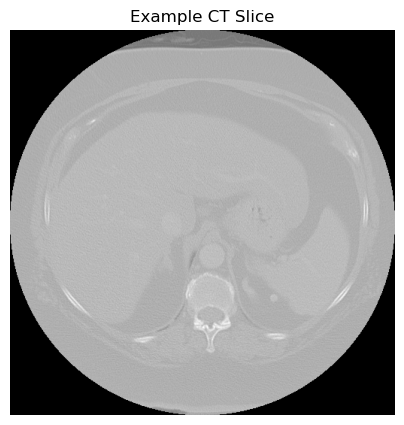

In [9]:
# show an example
ds = pydicom.dcmread(mrg["path"].iloc[0])
img = ds.pixel_array
plt.figure(figsize=(5,5))
plt.imshow(img, cmap="gray")
plt.title("Example CT Slice")
plt.axis("off")
plt.show()